# Load the Dataset

This code imports essential libraries for data manipulation, modeling, and visualization, with Pandas and NumPy for data processing, and scikit-learn for building a Gradient Boosting Regressor model. It also uses Matplotlib and Seaborn for visual analysis. Six datasets are loaded, including account details, fraud cases, account features, statements, and both domestic and international transaction data. These datasets will be used to develop a predictive model aimed at generating financial insights, such as estimating spending or determining appropriate credit line adjustments.

In [8]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
account_data = pd.read_csv('data/account_dim_20250325.csv')
fraud_case_data = pd.read_csv('data/fraud_claim_case_20250325.csv')
account_features = pd.read_csv('data/rams_batch_cur_20250325.csv')
statement_data = pd.read_csv('data/statement_fact_20250325.csv')
transaction_data = pd.read_csv('data/transaction_fact_20250325.csv')
wrld_transaction_data = pd.read_csv('data/wrld_stor_tran_fact_20250325.csv')


This code contains functions to clean and preprocess multiple datasets, including account, fraud, and transaction data. It ensures data quality by converting dates, removing unnecessary columns, handling missing values, and addressing anomalies.

For the account data, the code applies custom encoding to payment history data and creates a Payment_Hist_Sum column to capture overall payment behavior. Fraud data is cleaned and enriched with additional columns indicating recent fraud activity and large fraud amounts. Transaction data from both domestic and international sources is combined using the merge_transaction_data() function, focusing on sales transactions for analysis.

The processed transaction data is further aggregated to calculate the maximum transaction amount per account. This derived feature, named transaction_amt_max, serves as an essential indicator of spending behavior, which will be useful in building predictive models for financial analysis.

In [9]:
# Function to clean the RAMS dataset
def clean_rams(df):
    # Convert date column to datetime format
    df['cu_processing_date'] = pd.to_datetime(df['cu_processing_date'])

    # Keep only the latest processing date for each account
    latest_df = df.sort_values(by=['cu_processing_date'], ascending=False).drop_duplicates(subset=['cu_account_nbr'], keep='first')

    # drop the ca_cash_bal_pct_crd_line column
    df = df.drop(columns=['ca_cash_bal_pct_crd_line'])
    # irrelevant column as the values are all 0

    #drop the cu_nbr_days_dlq column
    df = df.drop(columns=['cu_nbr_days_dlq'])
    #redundant as theres a simialr column with months which is more useful

    #drop the ca_cash_bal_pct_cash_line column
    df = df.drop(columns=['ca_cash_bal_pct_cash_line'])

    #For all values in column cu_crd_bureau_scr , replace the value 0 with median of the column cu_crd_bureau_scr
    df['cu_crd_bureau_scr'] = df['cu_crd_bureau_scr'].replace(0, df['cu_crd_bureau_scr'].median())

    #drop the column cu_next_crd_line_rev_date
    df = df.drop(columns=['cu_next_crd_line_rev_date'])
    #irrelevant column as majority values are 0

    #dropping columns
    useless_col = [
        'cu_cur_balance',
        'ca_mob',
        'cu_rnd_nbr',
        'rb_crd_gr_new_crd_gr',
        'cu_processing_date',
        'mo_tot_sales_array_1',
        'mo_tot_sales_array_2',
        'mo_tot_sales_array_3',
        'mo_tot_sales_array_4',
        'mo_tot_sales_array_5',
        'mo_tot_sales_array_6'
    ]

    #Droping the above generated columns
    df = df.drop(columns=useless_col)

    # for the values 999999999999999 in cu_cash_line_am replace them with 20% of corresponding valur of cu_crd_bureau_scr column 
    df['cu_cash_line_am'] = df.apply(
        lambda row: row['cu_crd_bureau_scr'] * 0.2 if row['cu_cash_line_am'] == 999999999999999 else row['cu_cash_line_am'],
        axis=1
    )
    # round it off to 2 decimal places
    df['cu_cash_line_am'] = df['cu_cash_line_am'].round(2)

    #drop duplicate rows with duplicate values in the column cu_account_nbr
    df = df.drop_duplicates(subset=['cu_account_nbr'])

    return df

# Function to clean the account dataset
def clean_accounts(df):
    account_df = df.copy()

    # replace all \\\"\\\" values with NaN
    account_df.replace(r'\\\"', np.nan, regex=True, inplace=True)

    # drop duplicate rows
    account_df.drop_duplicates(inplace=True)
    
    # drop useless columns
    useless_column  = ['date_in_collection', # All values are null
                       'special_finance_charge_ind', # All values are null
                       'card_activation_date', # Redundant since we have card_activation_flag
                       'ebill_ind', # Not usefull for computing credit_line increase
                       'overlimit_type_flag', # All values are 0
                       'external_status_reason_code' # Redundant with ext_status_reason_cd_desc
                       ]
    account_df.drop(columns=useless_column, inplace=True, errors='ignore')

    # convert date columns to datetime
    date_columns = ['open_date']
    for col in date_columns:
        account_df[col] = pd.to_datetime(account_df[col], errors='coerce')

    # update the card_activation_flag to 0 or 1.
    account_df['card_activation_flag'] = account_df['card_activation_flag'].replace({'0': 1, '7': 0, '8': 0, np.nan: 0})

    # Create empty columns for each month
    for i in range(12):
        account_df[f"Month_{i+1}"] = account_df['payment_hist_1_12_mths'].apply(lambda x: x[i] if pd.notna(x) and i < len(x) else np.nan)

    for i in range(12):
        account_df[f"Month_{i+13}"] = account_df['payment_hist_13_24_mths'].apply(lambda x: x[i] if pd.notna(x) and i < len(x) else np.nan)

    # Drop the original payment history columns
    account_df.drop(columns=['payment_hist_1_12_mths', 'payment_hist_13_24_mths'], inplace=True)

    # Update the employee_code column.
    account_df['high_spending_customer'] = account_df['employee_code'].replace({'H': 1, 'Y': 0, '': 0, np.nan: 0})
    account_df['employee_code'] = account_df['employee_code'].replace({'Y': 1, 'H': 0, '': 0, np.nan: 0})

    return account_df

# Clean fraud data
def clean_fraud_data(df):
    # Convert date columns to datetime
    df['reported_date'] = pd.to_datetime(df['reported_date'], errors='coerce')

    # create a new column which is set to 1 if fraud happened in the last 12 months and 0 otherwise
    df['fraud_last_12_months'] = df['reported_date'].apply(lambda x: 1 if (pd.to_datetime('today') - x).days <= 365 else 0)
    # create a new column which is set to 1 if fraud amount is greater than 1000 and 0 otherwise
    df['fraud_amount_gt_1000'] = df['gross_fraud_amt'].apply(lambda x: 1 if x > 1000 else 0)

    # drop all column except the current_account_nbr, fraud_last_12_months and fraud_amount_gt_1000
    df = df[['current_account_nbr', 'fraud_last_12_months', 'fraud_amount_gt_1000']]

    return df

# Function to encode payment history_month columns in accounts dataset
def encode_pay_hist_month_in_accounts(df):
    # Define encoding dictionary
    encoding_dict = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7,  # No Activity
        'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7,  # Debit-Only Activity
        'I': 0, 'J': 1, 'K': 2, 'L': 3, 'M': 4, 'N': 5, 'O': 6, 'P': 7,  # Credit-Only Activity
        '%': 0, '#': 0, '+': 0, '--': 0, 'z': 0, 'Q': 0, 'Z': 0  # Neutral risk indicators
    }
    month_columns = ['Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6','Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12','Month_13', 'Month_14', 'Month_15', 'Month_16', 'Month_17', 'Month_18','Month_19', 'Month_20', 'Month_21', 'Month_22', 'Month_23', 'Month_24']
    df[month_columns] = df[month_columns].astype(str)
    # Apply encoding only to month columns
    df[month_columns] = df[month_columns].applymap(lambda x: encoding_dict.get(x, 0))

    return df

# Function to clean transaction data
def clean_transaction_data(transaction_df):

    df = transaction_df.copy()

    uselss_column=[
                'payment_type',
                'transaction_return_cnt',
                'transaction_sale_cnt',
                'product_amt',
                'product_qty',
                'invoice_nbr',
                'first_purchase_ind',
                'adj_orgn_tran_dt',
                'curr_markup_fee',
                'fcr_amount',
                'fcr_flag',
                'fcr_rate_of_exchange',
                'posting_date']
    
    #drop the useless columns
    df.drop(uselss_column,axis=1,inplace=True)

    return df

def merge_transaction_data(df1, df2):
    combined_transaction_df = pd.concat([df1, df2], ignore_index=True)
    # Filter for transactions of type 'SALE' and code 253
    transaction_sales_df = combined_transaction_df[(combined_transaction_df['transaction_type'] == 'SALE') & (combined_transaction_df['transaction_code'] == 253)]
    # Drop unnecessary columns
    transaction_sales_df.drop(columns=['transaction_type', 'transaction_code', 'frgn_curr_code', 'frgn_tran_amt', 'us_equiv_amt'], inplace=True)
    return transaction_sales_df


account_data = clean_accounts(account_data)
account_data = encode_pay_hist_month_in_accounts(account_data)
account_data['Payment_Hist_Sum'] = account_data.filter(like='Month_').sum(axis=1)
account_features = clean_rams(account_features)
fraud_data = clean_fraud_data(fraud_case_data)
combined_transaction_data = merge_transaction_data(transaction_data, wrld_transaction_data)

# group combined_transaction_data by account number and month and sum the transaction amount
combined_transaction_data['transaction_date'] = pd.to_datetime(combined_transaction_data['transaction_date'], errors='coerce')
combined_transaction_data['transaction_month'] = combined_transaction_data['transaction_date'].dt.to_period('M')
combined_transaction_data['transaction_month'] = combined_transaction_data['transaction_month'].astype(str)
combined_transaction_data = combined_transaction_data.groupby(['current_account_nbr', 'transaction_month']).agg({'transaction_amt': 'sum'}).reset_index()

# group by account number and find maximum transaction_month
combined_transaction_data = combined_transaction_data.groupby('current_account_nbr', as_index=False)['transaction_amt'].max()

# rename transaction_amt to transaction_amt_max
combined_transaction_data.rename(columns={'transaction_amt': 'transaction_amt_max'}, inplace=True)



/var/folders/h7/qn2fn7996dn7y9sp2_ptj5h40000gn/T/ipykernel_16962/3442529144.py:81: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  account_df[col] = pd.to_datetime(account_df[col], errors='coerce')
/var/folders/h7/qn2fn7996dn7y9sp2_ptj5h40000gn/T/ipykernel_16962/3442529144.py:84: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  account_df['card_activation_flag'] = account_df['card_activation_flag'].replace({'0': 1, '7': 0, '8': 0, np.nan: 0})
/var/folders/h7/qn2fn7996dn7y9sp2_ptj5h40000gn/T/i

This code merges multiple datasets using **current_account_nbr** as the primary key to create a comprehensive dataset for further analysis. It combines account data with statement data, aggregated transaction data, fraud data, and account features using a **left join**. This ensures all accounts are retained, even if they don't have matching records in some datasets.

After merging, any **NaN (missing)** values are replaced with `0` using `fillna()`, ensuring a clean dataset without null entries. This is particularly useful when dealing with missing transaction or fraud data for certain accounts. Finally, the shape of the merged dataset is printed to confirm the number of rows and columns, and the first few rows are displayed using `head()` for inspection. This prepared dataset will be used for further modeling and analysis.

In [10]:

# Merge datasets on the primary key (current_account_nbr)
merged_data = account_data.merge(statement_data, on="current_account_nbr", how="left") \
                          .merge(combined_transaction_data, on="current_account_nbr", how="left") \
                          .merge(fraud_data, on="current_account_nbr", how="left") \
                          .merge(account_features, left_on="current_account_nbr", right_on="cu_account_nbr", how="left")

# replace NaN values with 0 in the merged data
merged_data.fillna(0, inplace=True)

# Inspect merged data
print("Merged Data Shape:", merged_data.shape)
merged_data.head()


Merged Data Shape: (658685, 62)


,current_account_nbr,client_id,open_date,card_activation_flag,employee_code,pscc_ind,ext_status_reason_cd_desc,account_card_type,Month_1,Month_2,...,ca_current_utilz,cu_account_nbr,cu_line_incr_excl_flag,ca_max_dlq_lst_6_mnths,ca_mnths_since_active,ca_mnths_since_cl_chng,ca_nsf_count_lst_12_months,cu_otb,rb_new_bhv_scr,ca_avg_utilz_lst_3_mnths
0,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17 00:00:00-04:00,0.0,0.0,0,0,DUAL CARD,0,0,...,0.0,nTgalbpd5Rsol7CA,N,0.0,4.0,54.0,0.0,12900.0,742.0,0.0
1,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17 00:00:00-04:00,0.0,0.0,0,0,DUAL CARD,0,0,...,0.0,nTgalbpd5Rsol7CA,N,0.0,4.0,54.0,0.0,12900.0,742.0,0.0
2,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17 00:00:00-04:00,0.0,0.0,0,0,DUAL CARD,0,0,...,0.0,nTgalbpd5Rsol7CA,N,0.0,4.0,54.0,0.0,12900.0,742.0,0.0
3,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17 00:00:00-04:00,0.0,0.0,0,0,DUAL CARD,0,0,...,0.0,nTgalbpd5Rsol7CA,N,0.0,4.0,54.0,0.0,12900.0,742.0,0.0
4,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17 00:00:00-04:00,0.0,0.0,0,0,DUAL CARD,0,0,...,0.0,nTgalbpd5Rsol7CA,N,0.0,4.0,54.0,0.0,12900.0,742.0,0.0


In [11]:
print(merged_data.columns)

Index(['current_account_nbr', 'client_id', 'open_date', 'card_activation_flag',
       'employee_code', 'pscc_ind', 'ext_status_reason_cd_desc',
       'account_card_type', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10',
       'Month_11', 'Month_12', 'Month_13', 'Month_14', 'Month_15', 'Month_16',
       'Month_17', 'Month_18', 'Month_19', 'Month_20', 'Month_21', 'Month_22',
       'Month_23', 'Month_24', 'high_spending_customer', 'Payment_Hist_Sum',
       'billing_cycle_date', 'payment_hist_1_12_mths', 'return_check_cnt_2yr',
       'return_check_cnt_last_mth', 'return_check_cnt_py',
       'return_check_cnt_total', 'return_check_cnt_ytd', 'prev_balance',
       'transaction_amt_max', 'fraud_last_12_months', 'fraud_amount_gt_1000',
       'cu_bhv_scr', 'cu_nbr_of_plastics', 'ca_avg_utilz_lst_6_mnths',
       'cu_cash_line_am', 'cu_crd_bureau_scr', 'cu_crd_line', 'cu_cur_nbr_due',
       'ca_current_utilz', 'cu_acc

This code builds a **Gradient Boosting Regressor** model to predict credit limit adjustments for customer accounts. 

First, relevant features are selected from the merged dataset, focusing on payment behavior, fraud indicators, and credit utilization. A custom function, **calculate_credit_limit_adjustment()**, is defined to generate a target variable based on logical rules. This function applies adjustments to credit limits using factors such as recent fraud incidents, account delinquency, and transaction patterns.

The data is then split into **training** and **testing** sets using an 70-30 ratio. The **Gradient Boosting Regressor** model is trained using the training data to predict credit limit adjustments. After training, predictions are made on the test data, and model performance is evaluated using **Mean Squared Error (MSE)** and the **R-squared (R²)** score, which measure the accuracy and effectiveness of the model in making credit limit recommendations.

In [12]:
# Feature selection for credit limit adjustment prediction
features = [
    'Payment_Hist_Sum',
    'return_check_cnt_2yr',
    'transaction_amt_max',
    'cu_bhv_scr',
    'rb_new_bhv_scr', 
    'ca_avg_utilz_lst_6_mnths', 
    'cu_crd_bureau_scr', 
    'cu_cur_nbr_due', 
    'ca_max_dlq_lst_6_mnths', 
    'ca_mnths_since_active',
    'ca_nsf_count_lst_12_months',
    'ca_mnths_since_cl_chng', 
    'fraud_last_12_months', 
    'fraud_amount_gt_1000'
]

X = merged_data[features]

# Define target variable (recommended credit limit adjustment)
def calculate_credit_limit_adjustment(row):
    # Example formula: Adjust based on utilization, delinquency, and fraud indicators
    if row['fraud_amount_gt_1000'] > 0 or row['fraud_last_12_months'] > 1:
        return row['cu_crd_line'] * 0.8  # Reduce credit limit by 20%
    elif row['ca_avg_utilz_lst_6_mnths'] > 50 or row['cu_cur_nbr_due'] > 2:
        return row['cu_crd_line'] * 1.2  # Increase credit limit by 10%
    elif row['transaction_amt_max'] > 0.5 * row['cu_crd_line'] and row['ca_max_dlq_lst_6_mnths'] < 50:
        return row['cu_crd_line'] * 1.4
    else:
        return row['cu_crd_line'] * 1.1  # Increase credit limit by 20%

merged_data['Credit_Limit_Adjustment'] = merged_data.apply(calculate_credit_limit_adjustment, axis=1)

y = merged_data['Credit_Limit_Adjustment']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Gradient Boosting Regressor for prediction
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Predict on test data
y_pred = gb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-Squared Score: {r2}")


Mean Squared Error: 15015992.386405133
R-Squared Score: 0.7066299634474269


This code visualizes the **feature importance** of the Gradient Boosting Regressor model to understand which factors had the most influence on the credit limit adjustment predictions. The feature importance values are extracted using `gb_model.feature_importances_`, and a bar plot is generated using **Seaborn** to display the significance of each feature. This visualization helps in interpreting the model’s decision-making process.

Additionally, the code tests the model's predictions on a sample of the test data using `predict()`, displaying the predicted credit limit adjustments for the first 10 accounts. These sample predictions provide a quick view of how the model applies its learned patterns to make credit limit recommendations.

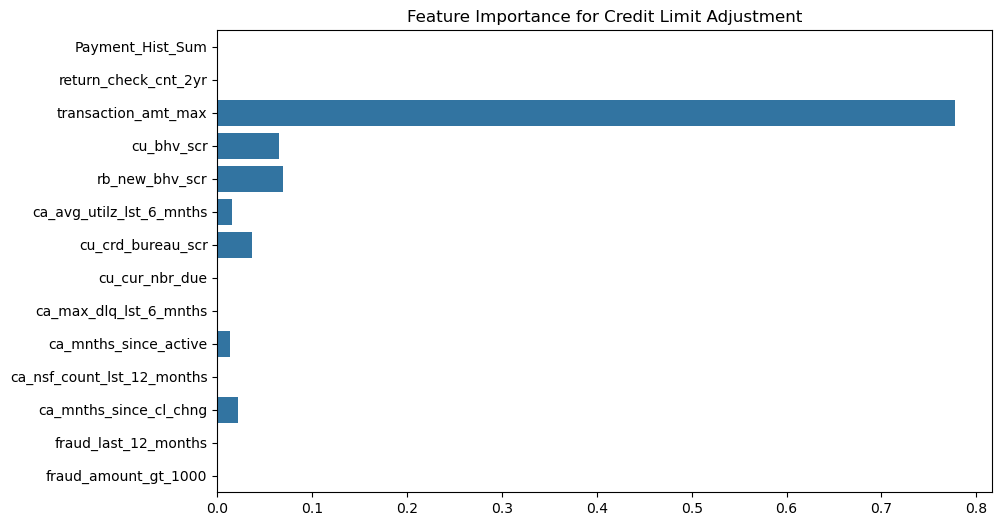

Sample Predictions: [13653.67383904  3020.57102277  4646.50523346   543.38407469
 18424.11271464  6227.60350877 18826.24804036 15486.05312504
  8005.77881988  3382.99724055]


In [13]:

# Visualize feature importance
feature_importance = gb_model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=features)
plt.title("Feature Importance for Credit Limit Adjustment")
plt.show()


# Test predictions
sample_predictions = gb_model.predict(X_test[:10])
print("Sample Predictions:", sample_predictions)


